### Import des modules

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import des données

In [37]:
data=pd.read_csv("/Users/mafaldafrere/Documents/Cours/IODAA/PROG/PROJET/classif_thyroid_disease/thyroidDF.csv")
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


Premières observations : 
- Des variables vont produire du data leakage (prise de traitement => malade) 
- Variables inutiles telles que "T4U_measured" => indique si NA ou pas dans la colonne "T4U"
- Beaucoup de NA sur certaines colonnes => comment gérer ? 
- Prédiction multi-classes (20 classes): réduire le nombre de classes
- Gestion de classes désiquilibrées

### 1. Exploration Préliminaire

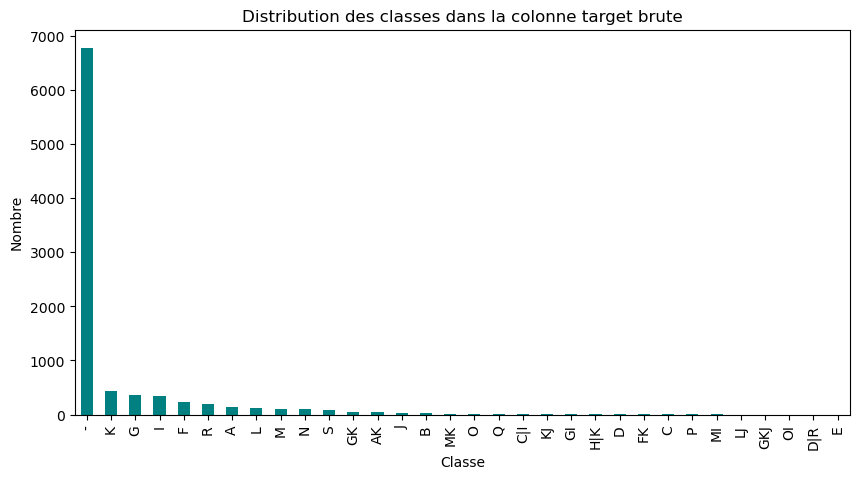

In [ ]:
y=data.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target brute")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On observe que les classes sont très déséquilibrées avec beaucoup d'individus sains et très peu d'individus pour les autres catégories. Je fais le choix de regrouper certaines catégories pour créer des méta-catégories : sain, hyperthyroïdie, hypothyroïdie (voir documentation du dataset kaggle). Je choisis aussi de retirer les catégories qui ne rentrent pas dans les méta-catégories car trop peu d'individus. 

In [39]:
# On mappe les meta-catégories
diagnostics = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

data['target'] = data['target'].map(diagnostics)

data.dropna(subset=['target'], inplace=True) # On retire les individus qui ne mappent pas dans les méta-catégories

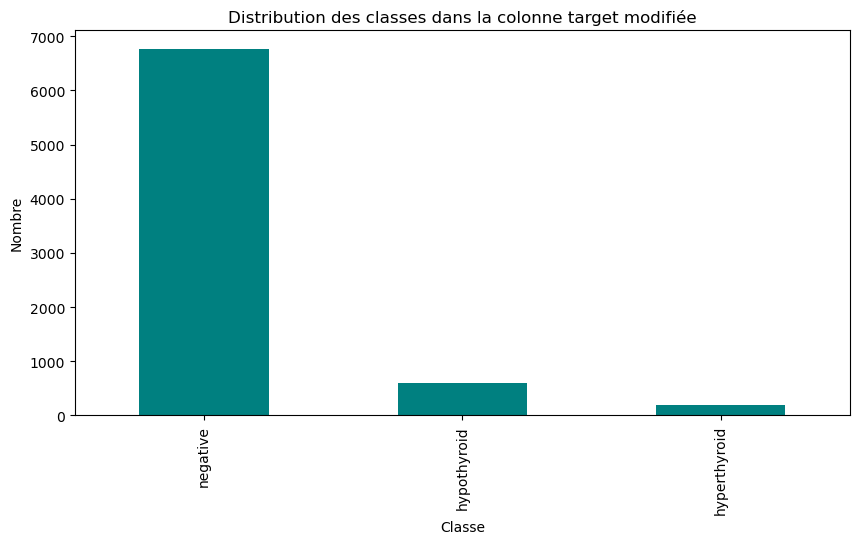

In [40]:
y=data.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target modifiée")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On reste dans un cas déséquilibré mais avec moins de classes et moins de bruit.
Maintenant on retire les colonnes redondantes qui indiquent si l'hormone a été mesurée ou non, car elles n'apportent aucune information supplémentaire.

In [41]:
data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
 'FTI_measured', 'TBG_measured'], axis=1, inplace=True)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 0 to 9171
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7546 non-null   int64  
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   object

In [43]:
# variables numériques
data.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,7546.000000,6824.000000,5337.000000,7192.000000,6870.000000,6877.000000,259.000000,7.546000e+03
mean,78.013782,5.421753,2.020935,105.203373,0.967322,110.571745,22.955019,8.529713e+08
std,1305.258137,26.080471,0.809865,32.606462,0.162315,36.600867,6.088392,7.561373e+06
min,1.000000,0.005000,0.050000,2.000000,0.190000,1.400000,0.100000,8.408010e+08
25%,37.000000,0.570000,1.600000,87.000000,0.870000,93.000000,20.000000,8.504100e+08
50%,55.000000,1.400000,2.000000,103.000000,0.960000,108.000000,23.000000,8.510090e+08
75%,67.000000,2.700000,2.300000,121.000000,1.060000,125.000000,27.000000,8.607111e+08
max,65526.000000,530.000000,18.000000,430.000000,2.120000,839.000000,45.000000,8.701190e+08


Observations :
- L'âge max est à 65526 ???

In [44]:
data[data.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,target,patient_id
2976,455,F,f,f,f,f,f,f,f,f,...,f,1.10,2.0,118.0,1.13,104.0,NaN,SVI,negative,850530001
5710,65511,M,f,f,f,f,f,f,f,f,...,f,0.38,2.0,113.0,1.08,104.0,NaN,other,negative,860210008
6392,65512,M,f,f,f,f,f,f,f,f,...,f,0.03,2.8,112.0,0.84,133.0,NaN,other,negative,860403050
8105,65526,F,f,f,f,f,f,f,f,f,...,f,1.50,NaN,132.0,1.02,129.0,NaN,other,negative,861014041


Je décide de retirer tous les individus d'âge supérieur à 100. De toute façon, ces individus sont sains. 

In [35]:
data['age'] = np.where((data.age > 100), np.nan, data.age)

Je regarde si il y a des duplicats de lignes, et de patient_ID. 

In [50]:
print(data.duplicated().any())
print(data.duplicated(subset=['patient_id']).any())

False
False


Il n'y a aucun duplicat donc je retire patient_id puisqu'il n'apporte aucune information. Je décide également de retirer la colonne "referral_source", qui indique par quel moyen le patient a effectué les tests pour les maladies de la thyroïde. Cette colonne pourrait apporter un biais (certaines sources peuvent amener plus de malades), et elle n'apporte pas beaucoup d'information de toute façon.  

In [51]:
data.drop(['patient_id', 'referral_source'], axis=1, inplace=True)

Finalement, plusieurs colonnes sont liées à un traitement médical post diagnostic ('on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds' 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid'). Dans le cadre d'un modèle de diagnostic, ce n'est pas très réaliste de les inclure. On va cependant les garder pour le moment et voir avec un premier modèle baseline si effectivement l'accuracy chute lorsqu'on les retire.

### 2. Premier Modèle, sans Feature Engineering 

J'ai décidé de faire un premier modèle avec un Random Forest, pour avoir un point de référence et éventuellement repérer des problèmes qu'il faudra corriger par la suite.

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7546 non-null   int64  
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   object

Je vois que la colonne TBG a 97% de valeurs manquantes donc pour ce premier modèle je retire la colonne. Je choisis ensuite de retirer les lignes où il y a des valeurs manquantes. 

In [55]:
data_baseline = data.drop(columns=['TBG'])
data_baseline = data_baseline.dropna()

print(data_baseline.shape)

(4659, 22)


On garde 4659 individus pour le modèle baseline, ce qui est suffisant pour un premier modèle. Evidemment, si il y a une corrélation entre la variable target et les occurences de Na, on le verra plus tard et on verra comment le gérer.

Modèle baseline RandomForest : 

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline.drop(columns=["target"])
y=data_baseline.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.81      0.74      0.77        23
 hypothyroid       0.97      1.00      0.99        75
    negative       0.99      0.99      0.99       834

    accuracy                           0.99       932
   macro avg       0.93      0.91      0.92       932
weighted avg       0.99      0.99      0.99       932



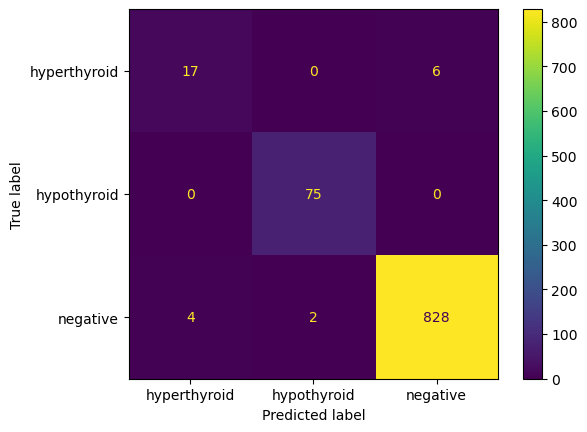

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

On a d'excellents résultats... Le modèle a juste un peu plus de mal à détecter l'hyperthyroïdie avec un recall à 0.74 mais le reste est quasiment parfait. C'est maintenant qu'on se questionne sur le data leakage et les variables post-diagnostic. 
=> On les retire pour voir...

In [62]:
leakage_features = [
    'on_thyroxine',
    'query_on_thyroxine',
    'on_antithyroid_meds',
    'thyroid_surgery',
    'I131_treatment',
    'query_hypothyroid',
    'query_hyperthyroid'
]

data_baseline2=data_baseline.drop(columns=leakage_features)

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline2.drop(columns=["target"])
y=data_baseline2.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.80      0.70      0.74        23
 hypothyroid       0.97      1.00      0.99        75
    negative       0.99      0.99      0.99       834

    accuracy                           0.99       932
   macro avg       0.92      0.90      0.91       932
weighted avg       0.99      0.99      0.99       932



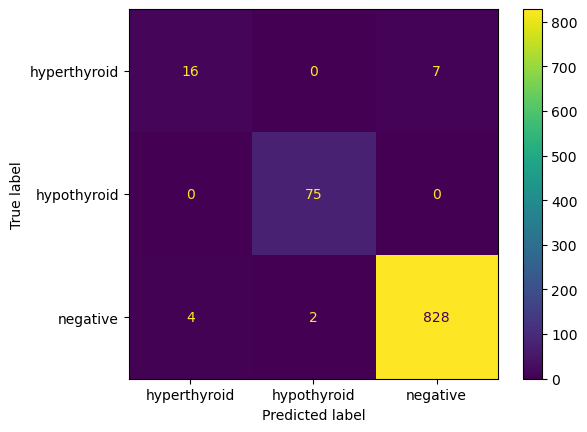

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

Le retrait des variables post-diagnostic ne semble pas vraiment affecter les performances du modèle, qui conserve une accuracy de 0.99.
Cela indique que les excellents résultats observés ne proviennent pas d’un effet de data leakage, mais plutôt du fort pouvoir explicatif des variables biologiques (TSH, T3, TT4, FTI…) directement liées au diagnostic médical.

In [66]:
variables_hormones = [
    'TSH', 'T3', 'TT4', 'T4U', 'FTI'
]

data_baseline3=data_baseline.drop(columns=variables_hormones)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline3.drop(columns=["target"])
y=data_baseline3.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.10      0.04      0.06        23
 hypothyroid       0.12      0.03      0.04        75
    negative       0.90      0.97      0.93       834

    accuracy                           0.87       932
   macro avg       0.37      0.35      0.35       932
weighted avg       0.81      0.87      0.84       932



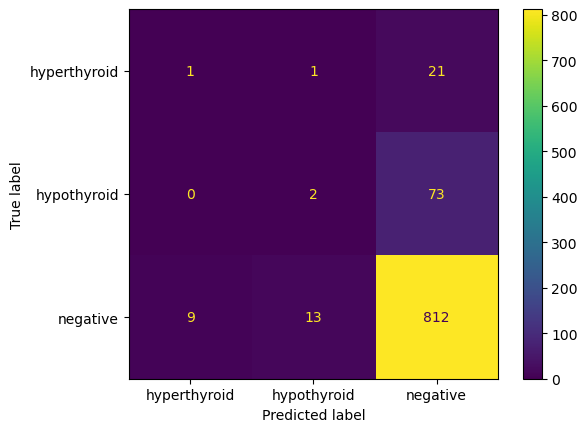

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

Sans les variables biologiques (TSH, T3, TT4, T4U, FTI), les performances chutent fortement : l’accuracy passe de 0.99 à 0.87, et les F1-scores pour les classes hyperthyroid et hypothyroid s’effondrent (≈0.05). Le modèle se contente de prédire la classe dominante.


**Discussion :**
Au vu de ces excellents résultats sur le modèle baseline, on va chercher à complexifier la prédiction en rajoutant des classes. On a deux angles d'approche : rajouter une méta-classe "Other" dans laquelle on ajoute toutes les targets que l'on avant éliminées car trop peu d'individus ET/OU sub-diviser les méta-classes en classes. 

#### 2. Feature engineering 